# Data loading 
Next cells are used to load the data we need.

In [3]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../../')


In [4]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('../data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [5]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [6]:
ICM_df = pd.read_csv('../data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [7]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [8]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

In [9]:
URM_all

<7947x25975 sparse matrix of type '<class 'numpy.float64'>'
	with 113268 stored elements in Compressed Sparse Row format>

In [10]:
ICM_all

<25975x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 490691 stored elements in Compressed Sparse Row format>

In [11]:
#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

In [22]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from KNN.UserKNNCFRecommender import UserKNNCFRecommender

recommender_ITEMCF = ItemKNNCFRecommender(URM_train)
recommender_ITEMCF.fit()
recommender_CBF = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender_CBF.fit()
recommender_userKNN = UserKNNCFRecommender(URM_train)
recommender_userKNN.fit()


ItemKNNCFRecommender: URM Detected 36 (0.45 %) cold users.
ItemKNNCFRecommender: URM Detected 1964 (7.56 %) cold items.
Similarity column 25975 ( 100 % ), 1943.47 column/sec, elapsed time 0.22 min
ItemKNNCBFRecommender: URM Detected 36 (0.45 %) cold users.
ItemKNNCBFRecommender: URM Detected 1964 (7.56 %) cold items.
Similarity column 25975 ( 100 % ), 1464.80 column/sec, elapsed time 0.30 min
UserKNNCFRecommender: URM Detected 36 (0.45 %) cold users.
UserKNNCFRecommender: URM Detected 1964 (7.56 %) cold items.
Similarity column 7947 ( 100 % ), 5916.35 column/sec, elapsed time 0.02 min


In [23]:
from Base.Recommender_utils import check_matrix, similarityMatrixTopK
from Base.BaseSimilarityMatrixRecommender import BaseItemSimilarityMatrixRecommender
import numpy as np

class ItemKNNScoresHybridNRecommender(BaseItemSimilarityMatrixRecommender):
    """ ItemKNNScoresHybridRecommender
    Hybrid of N prediction scores R

    """

    RECOMMENDER_NAME = "ItemKNNScoresHybridMultipleRecommender"


    def __init__(self, URM_train, recommender_array, number_of_recommenders):
        super(ItemKNNScoresHybridNRecommender, self).__init__(URM_train)
        self.number_of_recommenders = number_of_recommenders
        self.URM_train = check_matrix(URM_train.copy(), 'csr')
        self.recommender_array = recommender_array
        print('number of recommenders:',self.number_of_recommenders)


        
    def fit(self, weight_array):
        self.weight_array = weight_array


    def _compute_item_score(self, user_id_array, items_to_compute):
        item_weights = []
        for i in range(self.number_of_recommenders):
            print('entering cycle')
            item_weights.append(self.recommender_array[i]._compute_item_score(user_id_array))


        
        weighted_matrices = [a*b for a,b in zip(item_weights,self.weight_array)]
        print(weighted_matrices[0].shape)
        #item_weights_1 = self.Recommender_1._compute_item_score(user_id_array)
        #item_weights_2 = self.Recommender_2._compute_item_score(user_id_array)
        #item_weights_3 = self.Recommender_3._compute_item_score(user_id_array)
        #print('shape of item_weights hybrid N:', item_weights_1.shape)

        
        #item_weights = np.multiply(item_weights, self.weight_array)
        #item_weights = item_weights_1*self.alpha + item_weights_2*self.beta + item_weights_3*(1-self.alpha-self.beta)
        item_weights = sum(weighted_matrices)

        return item_weights

In [24]:
hybrid = ItemKNNScoresHybridNRecommender(URM_train, [recommender_ITEMCF,recommender_CBF, recommender_userKNN], 3)
hybrid.fit([0.5,0.4,0.1])
evaluator_validation.evaluateRecommender(hybrid)

ItemKNNScoresHybridMultipleRecommender: URM Detected 36 (0.45 %) cold users.
ItemKNNScoresHybridMultipleRecommender: URM Detected 1964 (7.56 %) cold items.
number of recommenders: 3
entering cycle
entering cycle
entering cycle
(1000, 25975)
entering cycle
entering cycle
entering cycle
(1000, 25975)
entering cycle
entering cycle
entering cycle
(1000, 25975)
entering cycle
entering cycle
entering cycle
(1000, 25975)
entering cycle
entering cycle
entering cycle
(1000, 25975)
entering cycle
entering cycle
entering cycle
(57, 25975)
EvaluatorHoldout: Processed 5057 ( 100.00% ) in 13.62 sec. Users per second: 371


({10: {'ROC_AUC': 0.1478509436864196,
   'PRECISION': 0.030353964801265027,
   'PRECISION_RECALL_MIN_DEN': 0.11957242985520627,
   'RECALL': 0.11707548726850064,
   'MAP': 0.054225106212956516,
   'MRR': 0.1087307864942826,
   'NDCG': 0.08168184107719426,
   'F1': 0.04820889136801997,
   'HIT_RATE': 0.3035396480126557,
   'ARHR': 0.12226012348120319,
   'NOVELTY': 0.004873091136680367,
   'AVERAGE_POPULARITY': 0.10057551859867842,
   'DIVERSITY_MEAN_INTER_LIST': 0.9872032406515096,
   'DIVERSITY_HERFINDAHL': 0.9987008025456601,
   'COVERAGE_ITEM': 0.43615014436958616,
   'COVERAGE_ITEM_CORRECT': 0.03437921077959576,
   'COVERAGE_USER': 0.6363407575185605,
   'COVERAGE_USER_CORRECT': 0.15074871020510885,
   'DIVERSITY_GINI': 0.1439848705965422,
   'SHANNON_ENTROPY': 11.574901549248056}},
 'CUTOFF: 10 - ROC_AUC: 0.1478509, PRECISION: 0.0303540, PRECISION_RECALL_MIN_DEN: 0.1195724, RECALL: 0.1170755, MAP: 0.0542251, MRR: 0.1087308, NDCG: 0.0816818, F1: 0.0482089, HIT_RATE: 0.3035396, ARHR

In [26]:
from KNN.ItemKNNScoresHybridMultipleRecommender import ItemKNNScoresHybridMultipleRecommender
hybrid = ItemKNNScoresHybridMultipleRecommender(URM_train, recommender_ITEMCF,recommender_CBF, recommender_userKNN )
hybrid.fit(alpha = 0.5, beta=0.4)
evaluator_validation.evaluateRecommender(hybrid)

ItemKNNScoresHybridMultipleRecommender: URM Detected 36 (0.45 %) cold users.
ItemKNNScoresHybridMultipleRecommender: URM Detected 1964 (7.56 %) cold items.
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (1000, 25975)
shape of item_weights: (57, 25975)
EvaluatorHoldout: Processed 5057 ( 100.00% ) in 12.18 sec. Users per second: 415


({10: {'ROC_AUC': 0.1478509436864196,
   'PRECISION': 0.030353964801265027,
   'PRECISION_RECALL_MIN_DEN': 0.11957242985520627,
   'RECALL': 0.11707548726850064,
   'MAP': 0.054225106212956516,
   'MRR': 0.1087307864942826,
   'NDCG': 0.08168184107719426,
   'F1': 0.04820889136801997,
   'HIT_RATE': 0.3035396480126557,
   'ARHR': 0.12226012348120319,
   'NOVELTY': 0.004873091136680367,
   'AVERAGE_POPULARITY': 0.10057551859867842,
   'DIVERSITY_MEAN_INTER_LIST': 0.9872032406515096,
   'DIVERSITY_HERFINDAHL': 0.9987008025456601,
   'COVERAGE_ITEM': 0.43615014436958616,
   'COVERAGE_ITEM_CORRECT': 0.03437921077959576,
   'COVERAGE_USER': 0.6363407575185605,
   'COVERAGE_USER_CORRECT': 0.15074871020510885,
   'DIVERSITY_GINI': 0.1439848705965422,
   'SHANNON_ENTROPY': 11.574901549248056}},
 'CUTOFF: 10 - ROC_AUC: 0.1478509, PRECISION: 0.0303540, PRECISION_RECALL_MIN_DEN: 0.1195724, RECALL: 0.1170755, MAP: 0.0542251, MRR: 0.1087308, NDCG: 0.0816818, F1: 0.0482089, HIT_RATE: 0.3035396, ARHR

In [15]:
import operator
index, value = max(enumerate(collaborative_MAP), key=operator.itemgetter(1))
print(index, value)
parameters = x_tick[index]
print(parameters)

45 0.03099426486845895
topk 625, shrink50


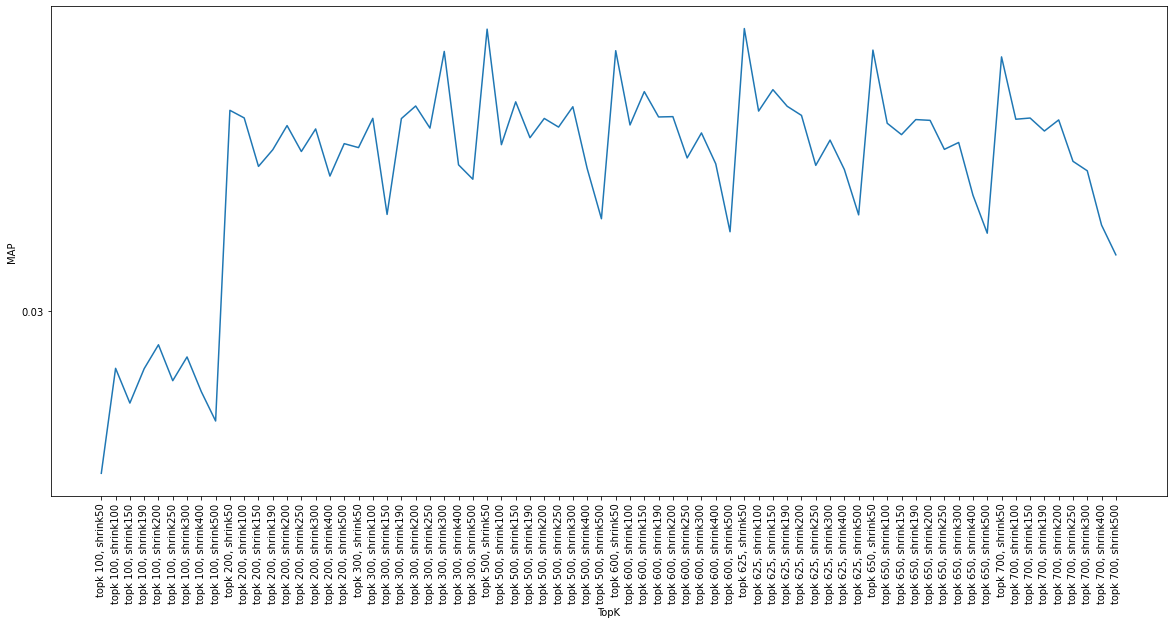

In [16]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(20, 9))
plt.plot(x_tick, collaborative_MAP, label="Collaborative")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

In [ ]:
# best model itemCBF topk 600, shrink200, weightTF-IDF

recommender = ItemKNNCBFRecommender(URM_all, ICM_all)
recommender.fit(topK=600, shrink=200, feature_weighting = 'TF-IDF')

user_id = test_users['user_id']
recommendations = recommender.recommend(user_id,cutoff = 10)


In [ ]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

In [ ]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
